In [48]:
import os
import gzip 
import pickle
import scipy.sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from sklearn.svm import SVC
from sklearn import metrics
from collections import Counter
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Load MNIST on Python 3.x

In [49]:
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

## Load USPS on Python 3.x

In [50]:
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

# Preparing Data for Training, Testing and Validation

In [51]:
training_img     = training_data[0]
training_label   = training_data[1]
testing_img      = test_data[0]
testing_label    = test_data[1]
validation_img   = validation_data[0]
validation_label = validation_data[1]

# LOGISTIC REGRESSION using SOFTMAX

In [52]:
def getLoss(w,x,y,lam):
    
    # takes the length of training
    m = x.shape[0] 
    # converting integer class into one-hot representation
    y_mat = oneHotIt(y) 
    # computing class scores given our input and current weights
    scores = np.dot(x,w) 
    # performing softmax on the scores to get the probabilities
    prob = softmax(scores) 
    # finding the loss of the probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) 
    # computing the gradient for that loss
    grad = (-1 / m) * np.dot(x.T,(y_mat - prob)) + lam*w 
    return loss,grad

def oneHotIt(Y):
    m = Y.shape[0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX

def softmax(z):
    z -= np.max(z)
    # softmax transformation
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

def getPrediction(X):
    probs = softmax(np.dot(X,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

def getAccuracy(X,Y):
    prob,prede = getPrediction(X)
    accuracy = sum(prede == Y)/(float(len(Y)))
    return accuracy,metrics.confusion_matrix(Y, prede),prede

In [53]:
# main section of softmax regression
w = np.zeros([training_img.shape[1],len(np.unique(training_label))])
lam = 0.001
epochs = 1000
learningRate = 0.01
losses = []
# updating weights on each epoch
for i in range(0, epochs):
    loss,grad = getLoss(w, training_img , training_label, lam)
    losses.append(loss)
    w = w - (learningRate * grad)

print('loss: ', loss)
print('Training Accuracy: ', getAccuracy(training_img, training_label)[0])
Acc, Con, LogRegPredictions = getAccuracy(testing_img, testing_label)
print('Testing Accuracy: ',Acc)
print('Confusion Matrix: \n',Con)
uspsAcc, uspsCon, uspsLogRegPredictions = getAccuracy(USPSMat, USPSTar)
print('USPS Accuracy: ', uspsAcc)
print('USPS Confusion Matrix: \n',Con)

loss:  0.629679249902
Training Accuracy:  0.85808
Testing Accuracy:  0.8718
Confusion Matrix: 
 [[ 946    0    3    3    0    4   15    1    8    0]
 [   0 1092    5    3    1    4    4    0   26    0]
 [  16   19  850   26   19    0   26   23   47    6]
 [   5    3   22  879    1   32    8   19   27   14]
 [   3    8    5    0  861    1   17    2   10   75]
 [  26   14    5   79   23  650   28    9   41   17]
 [  20    5   13    2   13   19  880    0    6    0]
 [   4   36   28    1   13    0    4  887   10   45]
 [   9   14   14   38   11   23   18   14  813   20]
 [  13   13   11   12   51   11    1   26   11  860]]
USPS Accuracy:  0.33206660333
USPS Confusion Matrix: 
 [[ 946    0    3    3    0    4   15    1    8    0]
 [   0 1092    5    3    1    4    4    0   26    0]
 [  16   19  850   26   19    0   26   23   47    6]
 [   5    3   22  879    1   32    8   19   27   14]
 [   3    8    5    0  861    1   17    2   10   75]
 [  26   14    5   79   23  650   28    9   41   17]


# KERAS MULTI LAYER NEURAL NETWORK MODEL

In [54]:
def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == 0):
            processedLabel.append([0])
        elif(labelInstance == 1):
            processedLabel.append([1])
        elif(labelInstance == 2):
            processedLabel.append([2])
        elif(labelInstance == 3):
            processedLabel.append([3])
        elif(labelInstance == 4):
            processedLabel.append([4])
        elif(labelInstance == 5):
            processedLabel.append([5])
        elif(labelInstance == 6):
            processedLabel.append([6])
        elif(labelInstance == 7):
            processedLabel.append([7])
        elif(labelInstance == 8):
            processedLabel.append([8])
        elif(labelInstance == 9):
            processedLabel.append([9])
    return np_utils.to_categorical(np.array(processedLabel),10)

def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return 0
    elif encodedLabel == 1:
        return 1
    elif encodedLabel == 2:
        return 2
    elif encodedLabel == 3:
        return 3
    elif encodedLabel == 4:
        return 4
    elif encodedLabel == 5:
        return 5
    elif encodedLabel == 6:
        return 6
    elif encodedLabel == 7:
        return 7
    elif encodedLabel == 8:
        return 8
    elif encodedLabel == 9:
        return 9

In [55]:
processedTrainingData  = np.array(training_img)
processedTrainingLabel = encodeLabel(training_label)
processedTestingData   = np.array(testing_img)
processedTestingLabel  = encodeLabel(testing_label)
processedUSPSData      = np.array(USPSMat)
processedUSPSLabel     = encodeLabel(USPSTar)

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard

import numpy as np

input_size = 784
drop_out = 0.2
first_dense_layer_nodes  = 650
second_dense_layer_nodes = 10

def get_model():
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('softmax'))
    
    model.summary()
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [57]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 650)               510250    
_________________________________________________________________
activation_7 (Activation)    (None, 650)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 650)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                6510      
_________________________________________________________________
activation_8 (Activation)    (None, 10)                0         
Total params: 516,760
Trainable params: 516,760
Non-trainable params: 0
_________________________________________________________________


In [58]:
validation_data_split = 0.2
num_epochs = 1000
model_batch_size = 50000
tb_batch_size = 100
early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

# Process Dataset
history = model.fit(processedTrainingData
                    , processedTrainingLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

Train on 40000 samples, validate on 10000 samples
Epoch 1/1000
40000/40000 [==============================] - 5s 134us/step - loss: 2.3047 - acc: 0.1766 - val_loss: 1.5319 - val_acc: 0.5974
Epoch 2/1000
40000/40000 [==============================] - 5s 133us/step - loss: 1.5403 - acc: 0.5811 - val_loss: 1.2936 - val_acc: 0.6343
Epoch 3/1000
40000/40000 [==============================] - 5s 133us/step - loss: 1.2994 - acc: 0.6322 - val_loss: 1.0445 - val_acc: 0.6777
Epoch 4/1000
40000/40000 [==============================] - 5s 133us/step - loss: 1.0462 - acc: 0.6795 - val_loss: 0.9249 - val_acc: 0.7440
Epoch 5/1000
40000/40000 [==============================] - 5s 130us/step - loss: 0.9261 - acc: 0.7426 - val_loss: 0.8467 - val_acc: 0.7636
Epoch 6/1000
40000/40000 [==============================] - 5s 137us/step - loss: 0.8496 - acc: 0.7584 - val_loss: 0.7742 - val_acc: 0.7890
Epoch 7/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.7733 - acc: 0.7881 - val_l

Epoch 59/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.2458 - acc: 0.9305 - val_loss: 0.2751 - val_acc: 0.9192
Epoch 60/1000
40000/40000 [==============================] - 5s 131us/step - loss: 0.2497 - acc: 0.9266 - val_loss: 0.2783 - val_acc: 0.9200
Epoch 61/1000
40000/40000 [==============================] - 5s 131us/step - loss: 0.2581 - acc: 0.9250 - val_loss: 0.2915 - val_acc: 0.9092
Epoch 62/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.2670 - acc: 0.9174 - val_loss: 0.2782 - val_acc: 0.9204
Epoch 63/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.2570 - acc: 0.9266 - val_loss: 0.2637 - val_acc: 0.9205
Epoch 64/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.2399 - acc: 0.9286 - val_loss: 0.2515 - val_acc: 0.9288
Epoch 65/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.2278 - acc: 0.9370 - val_loss: 0.2442 - val_acc: 0.9295
Epoch 66/1000

Epoch 117/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.1400 - acc: 0.9604 - val_loss: 0.1788 - val_acc: 0.9472
Epoch 118/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.1400 - acc: 0.9612 - val_loss: 0.1874 - val_acc: 0.9451
Epoch 119/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.1427 - acc: 0.9591 - val_loss: 0.1845 - val_acc: 0.9449
Epoch 120/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.1457 - acc: 0.9578 - val_loss: 0.1988 - val_acc: 0.9399
Epoch 121/1000
40000/40000 [==============================] - 5s 137us/step - loss: 0.1532 - acc: 0.9557 - val_loss: 0.1943 - val_acc: 0.9418
Epoch 122/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.1538 - acc: 0.9551 - val_loss: 0.1943 - val_acc: 0.9422
Epoch 123/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.1486 - acc: 0.9566 - val_loss: 0.1812 - val_acc: 0.9451
Epoch 

Epoch 175/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.1025 - acc: 0.9705 - val_loss: 0.1573 - val_acc: 0.9514
Epoch 176/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.1026 - acc: 0.9697 - val_loss: 0.1568 - val_acc: 0.9523
Epoch 177/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.0978 - acc: 0.9719 - val_loss: 0.1458 - val_acc: 0.9560
Epoch 178/1000
40000/40000 [==============================] - 5s 135us/step - loss: 0.0919 - acc: 0.9740 - val_loss: 0.1470 - val_acc: 0.9555
Epoch 179/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0888 - acc: 0.9751 - val_loss: 0.1423 - val_acc: 0.9574
Epoch 180/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0873 - acc: 0.9758 - val_loss: 0.1506 - val_acc: 0.9547
Epoch 181/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0918 - acc: 0.9741 - val_loss: 0.1493 - val_acc: 0.9558
Epoch 

Epoch 233/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0625 - acc: 0.9828 - val_loss: 0.1266 - val_acc: 0.9626
Epoch 234/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0634 - acc: 0.9827 - val_loss: 0.1331 - val_acc: 0.9622
Epoch 235/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0627 - acc: 0.9828 - val_loss: 0.1252 - val_acc: 0.9622
Epoch 236/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0627 - acc: 0.9826 - val_loss: 0.1304 - val_acc: 0.9622
Epoch 237/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.0603 - acc: 0.9839 - val_loss: 0.1225 - val_acc: 0.9633
Epoch 238/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0597 - acc: 0.9835 - val_loss: 0.1388 - val_acc: 0.9573
Epoch 239/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0648 - acc: 0.9812 - val_loss: 0.1335 - val_acc: 0.9598
Epoch 

Epoch 291/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0504 - acc: 0.9858 - val_loss: 0.1532 - val_acc: 0.9538
Epoch 292/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.0687 - acc: 0.9790 - val_loss: 0.1379 - val_acc: 0.9595
Epoch 293/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0666 - acc: 0.9786 - val_loss: 0.1320 - val_acc: 0.9600
Epoch 294/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0524 - acc: 0.9847 - val_loss: 0.1112 - val_acc: 0.9667
Epoch 295/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0379 - acc: 0.9905 - val_loss: 0.1092 - val_acc: 0.9675
Epoch 296/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0365 - acc: 0.9915 - val_loss: 0.1102 - val_acc: 0.9667
Epoch 297/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0358 - acc: 0.9916 - val_loss: 0.1089 - val_acc: 0.9677
Epoch 

Epoch 349/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0252 - acc: 0.9944 - val_loss: 0.1046 - val_acc: 0.9689
Epoch 350/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0252 - acc: 0.9948 - val_loss: 0.1066 - val_acc: 0.9680
Epoch 351/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.0253 - acc: 0.9944 - val_loss: 0.1057 - val_acc: 0.9685
Epoch 352/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0260 - acc: 0.9948 - val_loss: 0.1119 - val_acc: 0.9662
Epoch 353/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0284 - acc: 0.9927 - val_loss: 0.1119 - val_acc: 0.9663
Epoch 354/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0325 - acc: 0.9916 - val_loss: 0.1290 - val_acc: 0.9612
Epoch 355/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.0406 - acc: 0.9882 - val_loss: 0.1231 - val_acc: 0.9645
Epoch 

Epoch 407/1000
40000/40000 [==============================] - 5s 118us/step - loss: 0.0194 - acc: 0.9959 - val_loss: 0.1136 - val_acc: 0.9690
Epoch 408/1000
40000/40000 [==============================] - 5s 123us/step - loss: 0.0208 - acc: 0.9950 - val_loss: 0.1093 - val_acc: 0.9694
Epoch 409/1000
40000/40000 [==============================] - 5s 123us/step - loss: 0.0235 - acc: 0.9948 - val_loss: 0.1208 - val_acc: 0.9672
Epoch 410/1000
40000/40000 [==============================] - 5s 130us/step - loss: 0.0240 - acc: 0.9941 - val_loss: 0.1112 - val_acc: 0.9696
Epoch 411/1000
40000/40000 [==============================] - 5s 131us/step - loss: 0.0249 - acc: 0.9940 - val_loss: 0.1139 - val_acc: 0.9689
Epoch 412/1000
40000/40000 [==============================] - 5s 131us/step - loss: 0.0207 - acc: 0.9955 - val_loss: 0.1030 - val_acc: 0.9706
Epoch 413/1000
40000/40000 [==============================] - 5s 129us/step - loss: 0.0195 - acc: 0.9960 - val_loss: 0.1085 - val_acc: 0.9704
Epoch 

Epoch 465/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0193 - acc: 0.9948 - val_loss: 0.1031 - val_acc: 0.9711
Epoch 466/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0130 - acc: 0.9976 - val_loss: 0.1020 - val_acc: 0.9716
Epoch 467/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0118 - acc: 0.9984 - val_loss: 0.1016 - val_acc: 0.9720
Epoch 468/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0113 - acc: 0.9985 - val_loss: 0.1019 - val_acc: 0.9722
Epoch 469/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0118 - acc: 0.9984 - val_loss: 0.1017 - val_acc: 0.9718
Epoch 470/1000
40000/40000 [==============================] - 5s 135us/step - loss: 0.0108 - acc: 0.9985 - val_loss: 0.1022 - val_acc: 0.9718
Epoch 471/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0113 - acc: 0.9983 - val_loss: 0.1021 - val_acc: 0.9716
Epoch 

Epoch 523/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0148 - acc: 0.9964 - val_loss: 0.1312 - val_acc: 0.9642
Epoch 524/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0272 - acc: 0.9911 - val_loss: 0.1430 - val_acc: 0.9620
Epoch 525/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.0320 - acc: 0.9894 - val_loss: 0.1195 - val_acc: 0.9673
Epoch 526/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0190 - acc: 0.9945 - val_loss: 0.1069 - val_acc: 0.9714
Epoch 527/1000
40000/40000 [==============================] - 5s 134us/step - loss: 0.0102 - acc: 0.9983 - val_loss: 0.1025 - val_acc: 0.9714
Epoch 528/1000
40000/40000 [==============================] - 5s 132us/step - loss: 0.0082 - acc: 0.9991 - val_loss: 0.1025 - val_acc: 0.9725
Epoch 529/1000
40000/40000 [==============================] - 5s 133us/step - loss: 0.0078 - acc: 0.9991 - val_loss: 0.1022 - val_acc: 0.9723
Epoch 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018789484668>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000187895A94E0>], dtype=object)

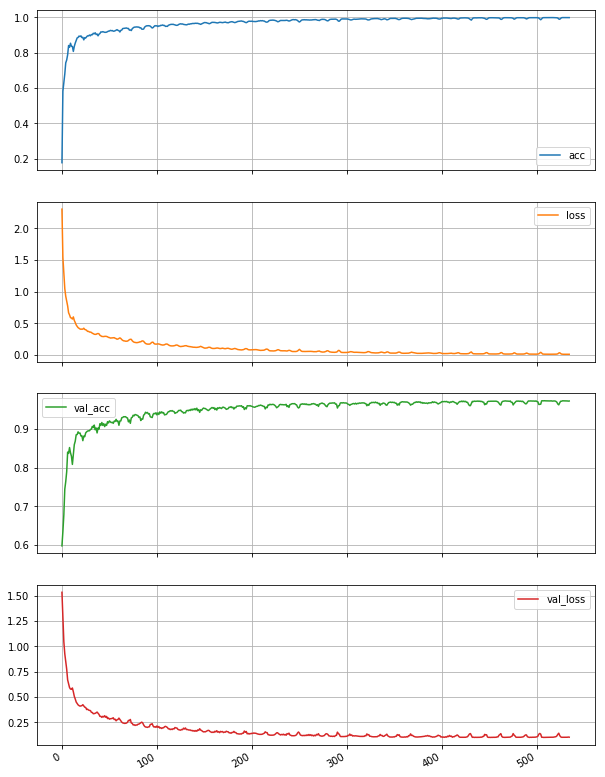

In [59]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [60]:
wrong   = 0
right   = 0
uw = 0
ur = 0

predictedTestLabel = []
predictedUSPSLabel = []

for i,j in zip(processedTestingData,processedTestingLabel):
    y = model.predict(np.array(i).reshape(-1,784))
    predictedTestLabel.append(decodeLabel(y.argmax()))
    
    if j.argmax() == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1

for i,j in zip(processedUSPSData,processedUSPSLabel):
    y = model.predict(np.array(i).reshape(-1,784))
    predictedUSPSLabel.append(decodeLabel(y.argmax()))
    
    if j.argmax() == y.argmax():
        ur = ur + 1
    else:
        uw = uw + 1

        
print("Errors: " + str(wrong), " Correct :" + str(right))
print("Testing Accuracy: " + str(right/(right+wrong)*100))
print("Test Confusion Matrix: \n",metrics.confusion_matrix(testing_label, predictedTestLabel))
print('====================USPS=========================')
print("Errors: " + str(uw), " Correct :" + str(ur))
print("USPS Accuracy: " + str(ur/(ur+uw)*100))
print("USPS Confusion Matrix: \n",metrics.confusion_matrix(USPSTar, predictedUSPSLabel))

Errors: 220  Correct :9780
Testing Accuracy: 97.8
Test Confusion Matrix: 
 [[ 973    0    0    3    0    0    1    1    2    0]
 [   0 1128    3    1    0    1    1    0    1    0]
 [   5    1 1005    2    3    0    2    7    6    1]
 [   0    0    1  998    0    2    0    3    4    2]
 [   1    0    2    1  961    0    3    3    2    9]
 [   2    0    0   17    1  860    2    3    5    2]
 [   3    4    0    1    4    4  937    0    5    0]
 [   1    3   11    5    3    0    0  998    1    6]
 [   1    0    4    8    4    5    1    5  942    4]
 [   2    5    0    8    7    3    0    6    0  978]]
====================USPS=========================
Errors: 13242  Correct :6757
USPS Accuracy: 33.78668933446672
USPS Confusion Matrix: 
 [[ 278    0  295  139   76  100  262  659   46  145]
 [  15  288  658  113  406   92   26  243  127   32]
 [  21   15 1562   66   17   85  141   57   31    4]
 [   2   16  443 1047    3  338   63   57   25    6]
 [   6   15  274   58  772   51   71  608  11

# RANDOM FOREST

In [61]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
clf.fit(training_img,training_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
validation_prediction = clf.predict(validation_img)
print("Validation Accuracy: " + str(accuracy_score(validation_label,validation_prediction)))

Validation Accuracy: 0.9722


In [63]:
test_prediction = clf.predict(testing_img)
print("Test Accuracy: " + str(accuracy_score(testing_label,test_prediction)))
print("Test Confusion Matrix \n", confusion_matrix(testing_label, test_prediction))

Test Accuracy: 0.966
Test Confusion Matrix 
 [[ 971    0    1    0    0    1    2    1    3    1]
 [   0 1121    2    4    0    2    2    0    3    1]
 [   6    0  998    6    1    0    4   10    7    0]
 [   0    0   15  965    0    9    0    9    9    3]
 [   2    0    2    0  949    0    5    0    2   22]
 [   3    0    0   15    4  852    8    2    6    2]
 [   7    3    1    0    4    4  934    0    5    0]
 [   1    2   23    1    2    0    0  986    2   11]
 [   4    0    4    7    4    7    5    3  927   13]
 [   6    4    2   11   12    4    1    6    6  957]]


In [64]:
USPS_prediction = clf.predict(USPSMat)
print("USPS Accuracy: "+ str(accuracy_score(USPSTar,USPS_prediction)))
print("USPS Confusion Matrix \n", confusion_matrix(USPSTar, USPS_prediction))

USPS Accuracy: 0.386469323466
USPS Confusion Matrix 
 [[ 599   10  225   51  465  148   71  168    1  262]
 [  22  601   90  119   51   67   18 1016   15    1]
 [  78   45 1172   83   58  181   18  356    6    2]
 [  42   12   86 1240   53  297    1  247    3   19]
 [   9  236   53   22 1074  136    9  418   20   23]
 [ 135   33  119   93   39 1379   24  166    3    9]
 [ 325   70  220   34  109  318  728  182    4   10]
 [  35  368  327  213   45  242   31  731    2    6]
 [  62   76  157  201  128 1022   73  135  119   27]
 [  16  303  224  263  256  122    7  666   57   86]]


# SVM

In [65]:
classifier = SVC(probability=False, kernel="rbf", C=3, gamma=.005)
classifier.fit(training_img, training_label)

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [66]:
ValPredicted = classifier.predict(validation_img)
print("Validation Accuracy: ", metrics.accuracy_score(validation_label, ValPredicted))

Validation Accuracy:  0.977


In [67]:
predicted = classifier.predict(testing_img)
print("Testing Accuracy: ", metrics.accuracy_score(testing_label, predicted))
print("Confusion matrix: \n" ,metrics.confusion_matrix(testing_label, predicted))

Testing Accuracy:  0.9748
Confusion matrix: 
 [[ 972    0    0    0    0    2    3    1    2    0]
 [   0 1126    3    1    0    1    1    1    2    0]
 [   3    2 1008    2    1    0    1    9    5    1]
 [   0    0    4  985    0    5    0    7    8    1]
 [   1    0    5    0  959    0    3    0    2   12]
 [   5    0    0   13    1  860    4    1    6    2]
 [   6    2    1    0    2    5  940    0    2    0]
 [   0    9   14    2    2    0    0  990    1   10]
 [   3    0    3    9    5    2    3    3  945    1]
 [   3    6    1    7   14    2    1    8    4  963]]


In [68]:
USPSPredicted = classifier.predict(USPSMat)
print("USPS Accuracy: ", metrics.accuracy_score(USPSTar, USPSPredicted))
print("Confusion matrix: \n" ,metrics.confusion_matrix(USPSTar, USPSPredicted))

USPS Accuracy:  0.399119955998
Confusion matrix: 
 [[ 592    1  397   39  176  330   54   70    2  339]
 [  87  405  360  144  141  152   26  651   18   16]
 [  70    6 1617   45   19  163   28   41    6    4]
 [  28    6  246 1190    1  477    0   43    3    6]
 [  14   41  164   26  985  282   16  344   51   77]
 [  66   12  283   68   11 1494   25   28   10    3]
 [ 147    5  685   24   50  289  771   13    1   15]
 [  43  144  468  439   25  317    6  528   17   13]
 [  71    9  258  261   51 1060   57   39  187    7]
 [  12   83  260  372  131  154    4  621  150  213]]


# ENSAMBLING USING MAXIMUM VOTING (HARD)

In [69]:
ensemblePredictions     = []
USPSensemblePredictions = []

er=0
ew=0
uer=0
uew=0

for i in range(0,len(testing_label)):
    vec=[]
    vec.append(LogRegPredictions[i])
    vec.append(predictedTestLabel[i])
    vec.append(test_prediction[i])
    vec.append(predicted[i])
    data=Counter(vec)
    pr=data.most_common(1)
    if(pr[0][1]>1):
        ensemblePredictions.append(pr[0][0])
    else:
        ensemblePredictions.append(predictedTestLabel[i])
        
    if ensemblePredictions[i]==testing_label[i]:
        er = er + 1
    else:
        ew = ew + 1
        
for i in range(0,len(USPSTar)):
    vec=[]
    vec.append(uspsLogRegPredictions[i])
    vec.append(predictedUSPSLabel[i])
    vec.append(USPS_prediction[i])
    vec.append(USPSPredicted[i])
    data=Counter(vec)
    pr=data.most_common(1)
    if(pr[0][1]>1):
        USPSensemblePredictions.append(pr[0][0])
    else:
        USPSensemblePredictions.append(predictedUSPSLabel[i])
    
    if USPSensemblePredictions[i]==USPSTar[i]:
        uer = uer + 1
    else:
        uew = uew + 1
        
print("Ensemble Test Accuracy: ", str(er/(er+ew)))
print("Ensemble Test Confusion Matrix: \n", metrics.confusion_matrix(testing_label, ensemblePredictions))

print("Ensemble USPS Accuracy: ", str(uer/(uer+uew)))
print("Ensemble USPS Confusion Matrix: \n", metrics.confusion_matrix(USPSTar, USPSensemblePredictions))

Ensemble Test Accuracy:  0.971
Ensemble Test Confusion Matrix: 
 [[ 973    0    1    0    0    0    2    1    3    0]
 [   0 1126    3    1    0    1    1    0    3    0]
 [   8    2 1003    2    1    0    1    8    6    1]
 [   0    0   13  978    0    3    0    5    8    3]
 [   1    0    3    0  953    0    4    1    2   18]
 [   5    0    0   21    2  849    4    1    8    2]
 [   7    3    1    0    4    6  933    0    4    0]
 [   1    6   22    1    3    0    0  982    1   12]
 [   3    0    4    8    4    1    4    6  942    2]
 [   6    7    2    7    7    1    1    4    3  971]]
Ensemble USPS Accuracy:  0.4030701535076754
Ensemble USPS Confusion Matrix: 
 [[ 647    2  371   58  272  120   86  155   10  279]
 [  90  427  350  161  223   75   18  548   97   11]
 [ 110   22 1560   50   31   97   45   66   13    5]
 [  54    8  240 1332   12  259   12   56   13   14]
 [  13  103  127   32 1089  138   21  331   99   47]
 [ 115   16  351  126   16 1246   39   66   19    6]
 [ 312  